In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

warnings.filterwarnings('ignore')



In [2]:
data = pd.read_excel("creprice_HousePriceData/区房价/广州区房价.xlsx", sheet_name="花都区")
data = data[['时间(年-月)', '价值(元/㎡)']]
data.Timestamp = pd.to_datetime(data['时间(年-月)'])
data.index = data.Timestamp

In [3]:
data = data.drop(['时间(年-月)'], axis=1)

In [4]:
data

,价值(元/㎡)
时间(年-月),
2019-03-01,9384
2019-02-01,9422
2019-01-01,9821
2018-12-01,9178
2018-11-01,9070
...,...
2014-07-01,7343
2014-06-01,7157
2014-05-01,7217


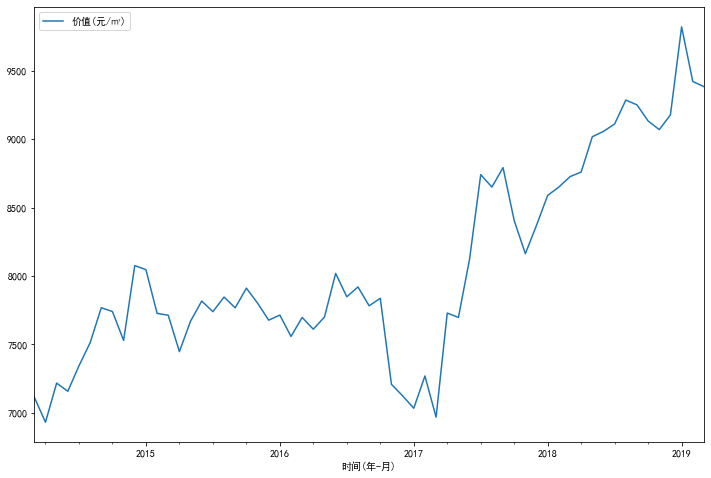

In [5]:
# price = pd.Series(data['价值(元/㎡)'], name='price')
# price.index = pd.Index(data['date'])

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
data.plot(figsize=(12, 8))
plt.show()

In [6]:
data.rename(columns = {"价值(元/㎡)": "price"}, inplace=True)
data = data.iloc[::-1]

In [7]:
ps = range(0, 5)
qs = range(0, 5)
ds = range(0, 5)

parameters = product(ps, ds, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷

for param in parameters_list:
    try:
#         model = ARIMA(data.price,order=(param[0], param[1], param[2])).fit()
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = sm.tsa.statespace.SARIMAX(data.price,
                                order=(param[0], param[1], param[2]),
                                #seasonal_order=(4, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())




最优模型:                                 SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   61
Model:               SARIMAX(2, 3, 4)   Log Likelihood                -371.221
Date:                Thu, 30 Apr 2020   AIC                            756.442
Time:                        12:08:40   BIC                            770.234
Sample:                    03-01-2014   HQIC                           761.746
                         - 03-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5144      0.071    -21.249      0.000      -1.654      -1.375
ar.L2         -0.9320      0.096     -9.745      0.000      -1.119      -0.745
ma.L1         -0.3456      0.704     -0.491  

In [8]:
# 设置future_month，需要预测的时间date_list
data2 = data[['price']]
future_month = 3
last_month = pd.to_datetime(data2.index[len(data2)-1])
date_list = []
for i in range(future_month):
    year = last_month.year
    month = last_month.month

    next_month_days = calendar.monthrange(year, month)[1]
    print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days) 
    date_list.append(last_month)
    if month == 12:
        month = 1
        year = year + 1
    else:
        month = month + 1
print('date_list=', date_list)

31
30
31
date_list= [Timestamp('2019-04-01 00:00:00'), Timestamp('2019-05-01 00:00:00'), Timestamp('2019-06-01 00:00:00')]


In [9]:

# # 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= data.columns)
data2 = pd.concat([data2, future])



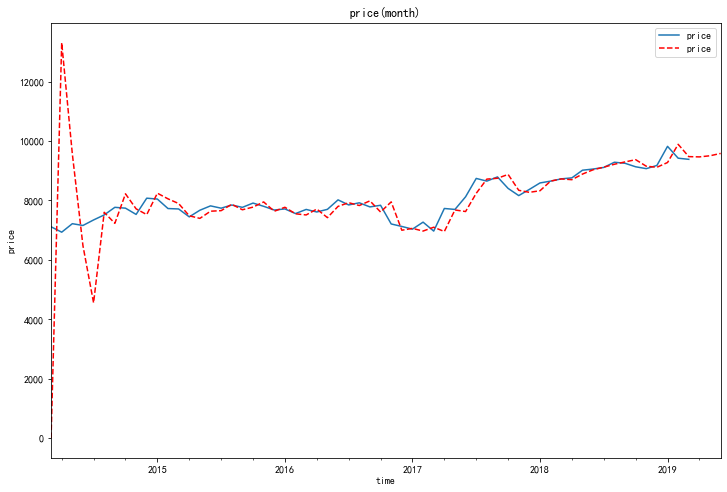

In [11]:
# get_prediction得到的是区间，使用predicted_mean
data2['forecast'] = best_model.get_prediction(start=0, end=len(data2)).predicted_mean

# 沪市指数预测结果显示
plt.figure(figsize=(12,8))
data2.price.plot(label='price')
data2.forecast.plot(color='r', ls='--', label='price')
plt.legend()
plt.title('price(month)')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [12]:
data2

,price
2014-03-01,7113
2014-04-01,6931
2014-05-01,7217
2014-06-01,7157
2014-07-01,7343
...,...
2019-02-01,9422
2019-03-01,9384
2014-04-01,NaN
2014-05-01,NaN


In [10]:
data2.price

2014-03-01    7113
2014-04-01    6931
2014-05-01    7217
2014-06-01    7157
2014-07-01    7343
              ... 
2019-02-01    9422
2019-03-01    9384
2019-04-01     NaN
2019-05-01     NaN
2019-06-01     NaN
Name: price, Length: 64, dtype: object

In [12]:
type(data2)

pandas.core.frame.DataFrame